# **COMP3670/6670 Assignment 3 - GMM**
---

**Enter Your Student ID:** u6828533

**Your Name:** Yuxuan Lin
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'u6828533.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'u6828533.ipynb' for programming and 'u6828533.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**

**Programming Section**
- 1 = 20%
- 2 = 20%
- 3 = 20%
- 4 = 7.5%
- 5 = 7.5%
- 6.1 = 5%
- 6.2 = 20%

---


**PROGRAMMING SECTION**
---


For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

We're going to implement an algorithm to model data with a mixture of gaussians. 

Remember the simplified EM algorithm in assignment 2 for k-means? Well, we're going to implement something similar.

The more complex aspect of this all is that your program must also correctly estimate the covariance matrices of the 2-dimensional gaussian components involved, as well as their means.

Not only this, but the "distance" of each of your data points (a row $d_i$ of $D$) from a gaussian $k$, is the probability of that point given that gaussian $p(d_i \mid k)$. 

Run the below cell to load the data we'll be using.

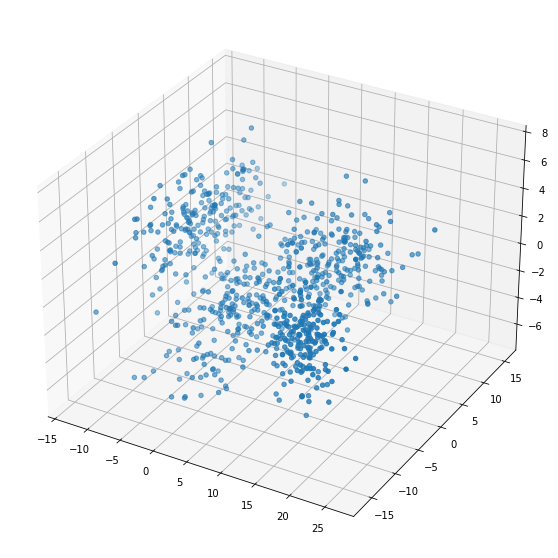

In [2]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 5 dimensions. The contribution of first three dimensions represented by a three dimensional Gaussian Mixture Model. The forth and fifth dimensions represented by another two dimensional GMM. 

**You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. For example, the first gaussian is $k = 1$. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number of datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilities, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

**REPEAT: You only need the first three dimensions of the data in task 1 through 5. The fourth and fifth dimensions are for task 6 only.**.

---

In [3]:
# λ for regularization of covariance matrix
_lambda = 1


def distance(p, q):
    """
    Calculate the Euclidean distance between two points
    """
    return np.sqrt(np.sum([(p[i] - q[i])**2 for i in range(len(p))]))


def initialise_parameters(X, K):
    """
    Initialize Σ (covarainces), 𝜇 (means), π (weights)
    """
    s_list, m_list, p_list = [], [], []

    for k in range(K):

        # Generate a random matrix M with specific size
        M = np.random.rand(X.shape[1], X.shape[1])

        # M @ M.T + λI ⇒ symmetric and positive-definite matrix
        # Inspired by Cholesky decomposition
        # Regularized to avoid singular matrix issues for multivariate_normal
        s_list.append(
            np.dot(M, np.transpose(M)) + _lambda * np.identity(X.shape[1]))
        """
        Alternative method : Singular Value Decomposition (SVD)   
        Source code from   : sklearn.datasets.make_spd_matrix
        
        # from scipy import linalg
        # U, _, Vt = linalg.svd(np.dot(X.T, X), check_finite=False)
        # s_list.append(np.dot(np.dot(U, 1.0 + np.diag(np.random.mtrand._rand.rand(X.shape[1]))), Vt))
        """

        # Probabilities are uniformly distributed at first
        p_list.append(1 / K)
    """ 
    Algorithm K-Means++ (modified for simplicity) 
    Hint: https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/kmeans.pdf
    """
    # Choose a datum at random to be the first cluster center
    m_list.append(X[random.randint(0, X.shape[0])])

    # Loop over the rest of the centers
    for k in range(1, K):
        distance_list = []

        # Loop over the data
        for n in range(X.shape[0]):
            closet_distance = math.inf

            # Compute and store the distance to the closest center
            for m in m_list:
                closet_distance = min(closet_distance, distance(X[n], m))
            distance_list.append(closet_distance)

        # Original algo: choose the datum using probability distribution
        # Modified algo: select the datum with maximum distance as the next center
        m_list.append(X[np.argmax(distance_list)].tolist())

    sigma, mu, pi = map(lambda x: np.array(x), [s_list, m_list, p_list])

    return sigma, mu, pi


K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print("\nSigma: \n", sigma)
print("\nMu: \n", mu)
print("\nPi: \n", pi)


Sigma: 
 [[[2.1837975  1.23989556 0.75075397]
  [1.23989556 2.82470338 1.26364969]
  [0.75075397 1.26364969 2.10626851]]

 [[1.65635969 0.82333887 0.69084066]
  [0.82333887 2.67065759 1.28853361]
  [0.69084066 1.28853361 2.4833223 ]]

 [[1.48506513 0.36999802 0.60983223]
  [0.36999802 1.38615668 0.55505406]
  [0.60983223 0.55505406 1.87022322]]

 [[1.44953098 0.4791696  0.8190796 ]
  [0.4791696  1.57965071 1.01835741]
  [0.8190796  1.01835741 2.93031802]]]

Mu: 
 [[ 19.10091999 -13.46294704   0.35167693]
 [ -5.17680762  15.39351857   0.48999601]
 [-13.17357905 -12.5939831   -1.81868203]
 [ 13.70785321   6.77393389   0.67539583]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

You cannot use euclidean distance like you did with the k-means algorithm in assignment 3.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [4]:
from scipy.stats import multivariate_normal


def E_step(pi, mu, sigma, X):
    return np.array([
        row / np.sum(row) for row in [[
            pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(X[i])
            for k in range(len(pi))
        ]
                                      for i in range(X.shape[0])]
    ])


responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[1.00000000e+000 8.24238270e-139 8.49203686e-089 1.22302164e-036]
 [1.00000000e+000 1.30616200e-251 2.64407437e-192 1.16241916e-081]
 [1.00000000e+000 3.37818930e-243 4.35037031e-191 1.30564628e-077]
 ...
 [1.61293436e-046 1.42666801e-073 4.96843172e-104 1.00000000e+000]
 [7.87180102e-042 9.02608961e-087 5.51776483e-122 1.00000000e+000]
 [4.51577924e-063 5.20306956e-063 1.10013753e-109 1.00000000e+000]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [5]:
def M_step(r, X):
    # Each cluster's total allocated responsibility
    nk = np.sum(r, axis=0)

    # Means update
    mu = np.dot(np.transpose(r), X) / nk.reshape(len(nk), 1)

    # Covariances update
    sigma = np.array([
        np.dot(np.multiply(r[:, k], np.transpose(X - mu[k])), X - mu[k]) / nk[k]
        for k in range(r.shape[1])
    ])

    # Weights update
    pi = nk / X.shape[0]

    return mu, sigma, pi


mu, sigma, pi = M_step(responsibilities, X[:, :3])
print("\nSigma: \n", sigma)
print("\nMu: \n", mu)
print("\nPi: \n", pi)


Sigma: 
 [[[14.73394559 -3.66794143  2.91361704]
  [-3.66794143  4.34285266 -0.13252519]
  [ 2.91361704 -0.13252519  4.91736156]]

 [[ 5.00693508 -1.30480144 -1.18274226]
  [-1.30480144 10.8256848   2.93552737]
  [-1.18274226  2.93552737  5.70453321]]

 [[12.90570733 -4.5344502  -7.43121621]
  [-4.5344502  11.49669949  6.3995998 ]
  [-7.43121621  6.3995998  11.71079264]]

 [[27.20336656  9.90682996  7.13417588]
  [ 9.90682996 11.26302595  4.49013255]
  [ 7.13417588  4.49013255  6.02508755]]]

Mu: 
 [[ 15.64130082 -10.19223867  -0.09273677]
 [ -5.49594184   3.63040573   0.78126033]
 [ -5.49542228  -5.0714234   -0.14883183]
 [  8.68752251   1.11786224  -0.41444393]]

Pi: 
 [0.25484914 0.16695863 0.2002611  0.37793113]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [6]:
def classify(pi, mu, sigma, x):
    # Note: the return value starts from 0
    return np.argmax([
        multivariate_normal(mu[k], sigma[k]).pdf(x) * pi[k]
        for k in range(len(pi))
    ])


print(classify(pi, mu, sigma, X[270, :3]))

2


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---


Sigma: 
 [[[ 1.34463855e+01 -5.17805499e+00  2.10492951e+00]
  [-5.17805499e+00  3.27164076e+00 -5.38563869e-01]
  [ 2.10492951e+00 -5.38563869e-01  4.58606161e+00]]

 [[ 1.35163429e+01  4.25309975e+00  1.64314414e+00]
  [ 4.25309975e+00  1.59337596e+01  4.43267854e+00]
  [ 1.64314414e+00  4.43267854e+00  3.36952629e+00]]

 [[ 2.35804494e+00  4.80962773e+00  7.91168552e-01]
  [ 4.80962773e+00  2.52485804e+01 -9.87971202e-01]
  [ 7.91168552e-01 -9.87971202e-01  4.48303384e+00]]

 [[ 1.93595441e+01  1.86723893e-02  2.91282497e+00]
  [ 1.86723893e-02  2.16771699e+00  8.56667052e-02]
  [ 2.91282497e+00  8.56667052e-02  4.73754899e+00]]]

Mu: 
 [[ 15.61053285 -10.2559241   -0.07023584]
 [  1.08816553  -3.6620783   -2.70166245]
 [ -7.12723552   0.65798122   1.77627539]
 [ 11.50140134   2.96783346   0.6352023 ]]

Pi: 
 [0.25167857 0.24743352 0.25271066 0.24817725]


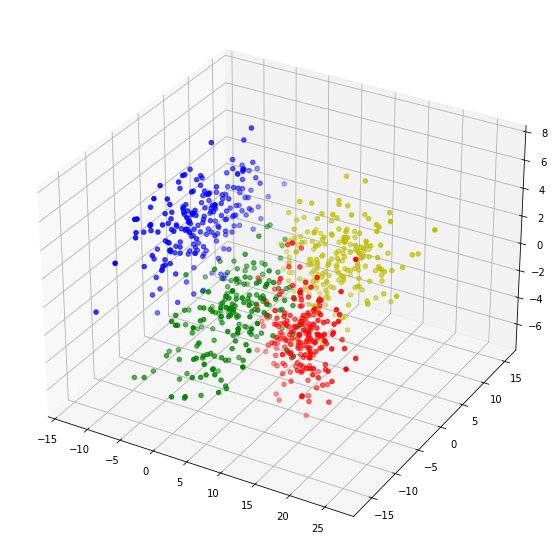

In [7]:
def EM(X, K, iterations):
    # Initialize parameters
    sigma, mu, pi = initialise_parameters(X, K)

    # Repeat until convergence
    for _ in range(iterations):

        # E-step: evaluate responsibilities for evry data point using current parameters
        responsibilities = E_step(pi, mu, sigma, X)

        # M-step: re-estimate parameters using the current responsibilities
        mu, sigma, pi = M_step(responsibilities, X)

    return mu, sigma, pi


# Test code. Leave it aloooooone!
iterations = 30
K = 4
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)
print("\nSigma: \n", sigma_1)
print("\nMu: \n", mu_1)
print("\nPi: \n", pi_1)


def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)


colours = ["r", "g", "b", "y"]
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], c=colours[k])
plt.show()

Now we start to use the forth and fifth dimension. First, we plot the forth and fifth dimension.

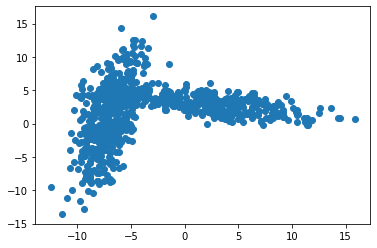

In [8]:
plt.scatter(X[:, 3], X[:, 4])
plt.show()

It is clearly that the number of Gaussians (K) for the second GMM equals to 2.

**TASK 6.1:** Compute the $\mu, \pi, \Sigma$ of the second GMM

In [9]:
mu_2, sigma_2, pi_2 = EM(X[:, [3, 4]], 2, 30)

**TASK 6.2:** Conditional Distribution.

Using the function from the Task 4. Using the $\mu, \pi, \Sigma$ to calculate the conditional distribution.

Let $K$ stands for the classification result of the first three dimensions, $Y$ stands for the classification result of the second dimensions.

Possible $k$ values are 0, 1, 2, 3. Possible $y$ values are 0, 1. 

Compute the conditional distribution $p(Y = y|K = k)$.

In [10]:
def conditional_distribution(X, k, y, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2):
    count_k, count_y_and_k = 0, 0

    for i in range(X.shape[0]):

        if classify(pi_1, mu_1, sigma_1, X[i, :3]) == k:
            count_k += 1

            if classify(pi_2, mu_2, sigma_2, X[i, [3, 4]]) == y:
                count_y_and_k += 1

    return count_y_and_k / count_k

In [11]:
a = conditional_distribution(X, 0, 0, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
b = conditional_distribution(X, 0, 1, mu_1, pi_1, sigma_1, mu_2, pi_2, sigma_2)
print(a + b)  # The answer should equal(or almost equal) to one.

1.0
